In [22]:
import numpy as np

import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax import jit, vmap, pmap, grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# MLP training on MNIST

In [3]:
# TODO: init MLP and add the predict
# TODO: add data loading in PyTorch
# TODO: ad the training loop, loss fn

In [4]:
seed = 0
mnist_img_size = (28, 28)
batch_size = 128

def init_MLP(layer_widths, rng_key, scale=0.01):

    params = []
    keys = jax.random.split(rng_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)

        params.append([
            scale * jax.random.normal(weight_key, (out_width, in_width)),    # weight
            scale * jax.random.normal(bias_key, (out_width,))                 # bias
        ])

    return params

# tests
key = jax.random.PRNGKey(0)
MLP_params = init_MLP([784, 512, 256, 10], key)

print(jax.tree.map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [13]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    for w, b in hidden_layers:
        x = jnp.dot(w, x) + b
        x = jax.nn.relu(x)

    w_final, b_final = params[-1]
    logits = jnp.dot(w_final, x) + b_final
    return logits - logsumexp(logits)

# tests
dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

predict = jax.jit(MLP_predict)
print(predict(MLP_params, dummy_img_flat).shape)

batched_MLP_predict = jit(vmap(MLP_predict, in_axes=(None, 0)))
print(batched_MLP_predict(MLP_params, np.stack([dummy_img_flat, dummy_img_flat])).shape)

(784,)
(10,)
(2, 10)


In [6]:
def custom_transform(img):
    img = np.array(img, dtype=np.float32).reshape(-1)

    return img

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    images = np.stack(transposed_data[0])
    labels = np.array(transposed_data[1])

    return (images, labels)


train_dataset = MNIST(root='./train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='./test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

batch_data = next(iter(train_loader))
print(batch_data[0].shape)  # images shape
print(batch_data[1].shape)  # labels shape
print(type(batch_data[0]))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 909796.64it/s] 


Extracting ./train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134107.66it/s]


Extracting ./train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 852524.97it/s] 


Extracting ./train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4531524.45it/s]


Extracting ./train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4180898.87it/s]


Extracting ./test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./test_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 58660.87it/s]


Extracting ./test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./test_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1270897.07it/s]


Extracting ./test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2806501.00it/s]

Extracting ./test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test_mnist/MNIST/raw

(128, 784)
(128,)
<class 'numpy.ndarray'>


In [10]:
num_epochs = 10


def loss_fn(params, imgs, gt_labels):
    predictions = batched_MLP_predict(params, imgs)   # (b, 10)

    return -jnp.mean(predictions * gt_labels)

@jit
def update(params, imgs, gt_labels, lr=0.001):
    loss, grads = jax.value_and_grad(loss_fn)(params, imgs, gt_labels)
    return loss, jax.tree.map(lambda x, y: x - lr * y, params, grads)

def accuracy(params, imgs, gt_labels):
    predictions = batched_MLP_predict(params, imgs)
    return jnp.mean(jnp.argmax(predictions, axis=1) == gt_labels)


for epoch in range(num_epochs):

    for imgs, labels in train_loader:
        gt_labels = jax.nn.one_hot(labels, 10)

        loss, MLP_params = update(MLP_params, imgs, gt_labels)

    print(loss)

0.026396247
0.034232005
0.02659723
0.03208719
0.019675748
0.028255003
0.017632565
0.021320753
0.0277717
0.017740807


In [14]:
accuracy(MLP_params, *next(iter(test_loader)))

Array(0.953125, dtype=float32)

In [20]:
print(type(MLP_params[0][0]))

<class 'jaxlib.xla_extension.ArrayImpl'>


# Visualizations

7 - 7


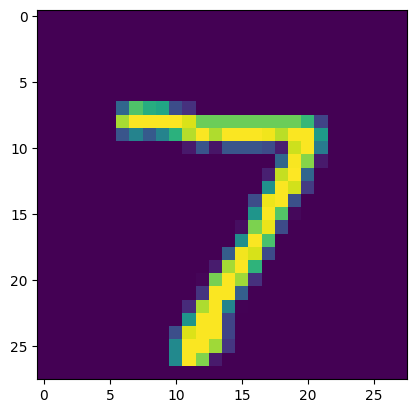

In [25]:
imgs, labels = next(iter(test_loader))

predict = batched_MLP_predict(MLP_params, jnp.expand_dims(imgs[0], 0))
print(predict.argmax(), '-', labels[0])

img = imgs[0].reshape(mnist_img_size)
plt.imshow(img); plt.show()

In [ ]:
# TODO: visualize the MLP weight
# TODO: visualize embeddings using t-SNE
# TODO: dead neurons

In [26]:
w = MLP_params[0][0]
print(w.shape)

(512, 784)


# Parallelization